Import the necessery libraries

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

Load and split the data

In [2]:
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

path =''
image_path = os.path.join(path,'dataset/semantic_drone_dataset/original_images/')
mask_path = os.path.join(path,'dataset/semantic_drone_dataset/label_images_semantic/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
image_list = sorted(image_list)
mask_list = sorted(mask_list)
train_image_list = image_list[:390]
train_mask_list = mask_list[:390]

validation_image_list = image_list[390:400]
validation_mask_list = mask_list[390:400]

print("number of train images is : {} ".format(len(train_image_list)))
print("number of train masks is : {} ".format(len(train_mask_list)))

print("number of train images is : {} ".format(len(validation_image_list)))
print("number of train masks is : {} ".format(len(validation_mask_list)))

print(image_list[0])
print(mask_list[0])

number of train images is : 390 
number of train masks is : 390 
number of train images is : 10 
number of train masks is : 10 
dataset/semantic_drone_dataset/original_images/000.jpg
dataset/semantic_drone_dataset/label_images_semantic/000.png


C:\Users\pulin\AppData\Local\Temp\ipykernel_18724\4255563497.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img  = imageio.imread(train_image_list[n])


(4000, 6000, 3)
(4000, 6000)


C:\Users\pulin\AppData\Local\Temp\ipykernel_18724\4255563497.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(train_mask_list[n])


Text(0.5, 1.0, 'Mask')

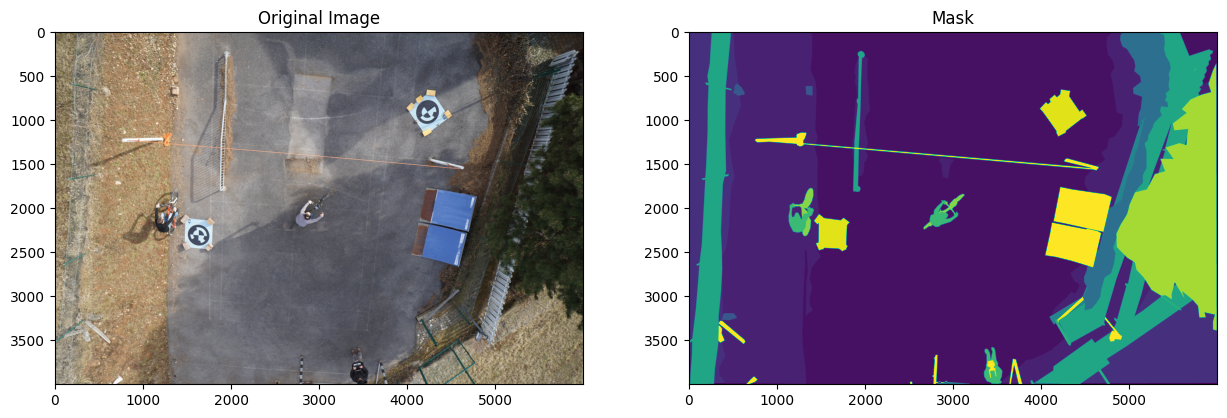

In [3]:
n = 10 # you can chose any index
img  = imageio.imread(train_image_list[n])
print(img.shape)
mask = imageio.imread(train_mask_list[n])
print(mask.shape)

# now let's plot
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

In [4]:
train_images = tf.constant(train_image_list)
train_masks = tf.constant(train_mask_list)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))
for image,mask in train_dataset.take(1) :
    print(image)
    print(mask)

validation_images = tf.constant(validation_image_list)
validation_masks = tf.constant(validation_mask_list)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images,validation_masks))
for image,mask in validation_dataset.take(1) :
    print(image)
    print(mask)

tf.Tensor(b'dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/semantic_drone_dataset/label_images_semantic/000.png', shape=(), dtype=string)
tf.Tensor(b'dataset/semantic_drone_dataset/original_images/586.jpg', shape=(), dtype=string)
tf.Tensor(b'dataset/semantic_drone_dataset/label_images_semantic/586.png', shape=(), dtype=string)


Preprocess Data

In [5]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) #this do the same as dividing by 255 to set the values between 0 and 1 (normalization)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=3)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

def preprocess(image,mask) :
    input_image = tf.image.resize(image,(96,128),method='nearest')
    input_mask = tf.image.resize(mask,(96,128),method='nearest')

    return input_image , input_mask

train_image_ds = train_dataset.map(process_path) # apply the preprocces_path function to our train_dataset
#print(image_ds)
train_processed_image_ds = train_image_ds.map(preprocess) # apply the preprocess function to our train_dataset

validation_image_ds = validation_dataset.map(process_path) # apply the preprocces_path function to our validation_dataset
#print(image_ds)
validation_processed_image_ds = validation_image_ds.map(preprocess)


Encoder (Downsampling Block)

In [6]:
def conv_block(inputs, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

Decoder (Upsampling Block)¶

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(n_filters, 3, strides=(2,2), padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    return conv

Build the U-Net Model

In [10]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

Set model Dimensions

In [11]:
img_height = 96
img_width = 128
num_channels = 3

# Create the UNet model
unet = unet_model(input_size=(img_height, img_width, num_channels))


#Model Summary

In [13]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

#Loss Function

In [14]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the Model

In [15]:
EPOCHS = 200
VAL_SUBSPLITS = 5
BUFFER_SIZE = 390
BATCH_SIZE = 16

# train
train_processed_image_ds.batch(BATCH_SIZE)
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_processed_image_ds.element_spec)

# validation
validation_processed_image_ds.batch(BATCH_SIZE)
validation_dataset = validation_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(validation_processed_image_ds.element_spec)


model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/200
25/25 [==============================] - 239s 281ms/step - loss: 2.4552 - accuracy: 0.3543
Epoch 2/200
25/25 [==============================] - 2s 86ms/step - loss: 2.0389 - accuracy: 0.4766
Epoch 3/200
25/25 [==============================] - 2s 85ms/step - loss: 1.8410 - accuracy: 0.5030
Epoch 4/200
25/25 [==============================] - 2s 86ms/step - loss: 1.6447 - accuracy: 0.5323
Epoch 5/200
25/25 [==============================] - 2s 87ms/step - loss: 1.5728 - accuracy: 0.5515
Epoch 6/200
25/25 [==============================] - 2s 86ms/step - loss: 1.6091 - accuracy: 0.5273
Epoch 7/200
25/25 [==============================] - 2s 86ms/step - loss: 1.4508 - accuracy: 0.5669
Epoch 8/200
25/25 [==============================] - 2s

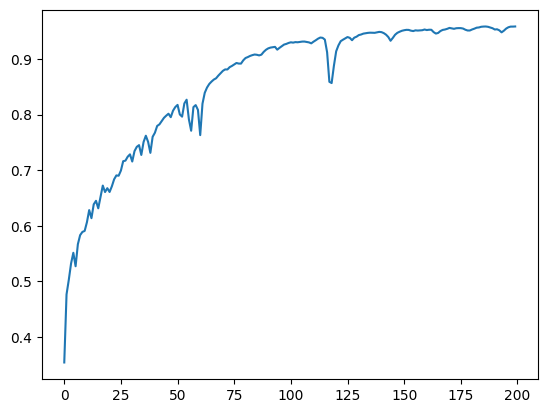

In [16]:
plt.plot(model_history.history["accuracy"])

In [17]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

#Predicted Masks

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

1/1 [==============================] - 0s 23ms/step


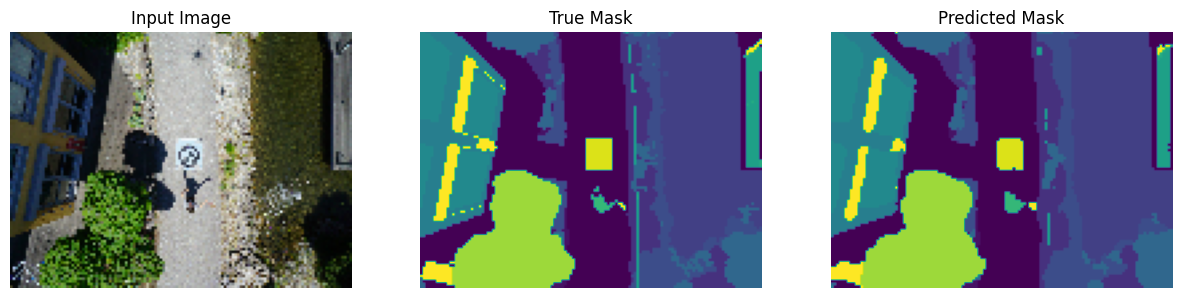

1/1 [==============================] - 0s 21ms/step


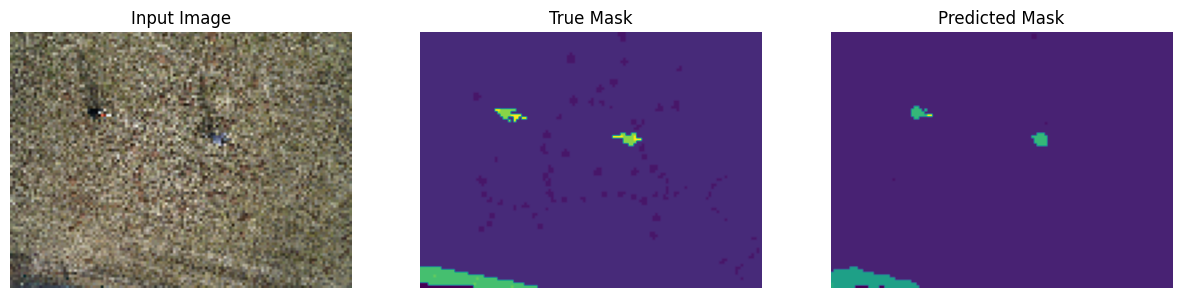

1/1 [==============================] - 0s 23ms/step


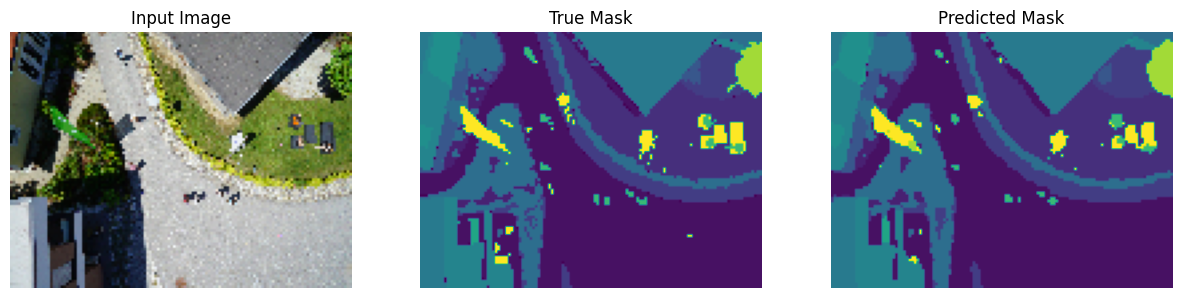

1/1 [==============================] - 0s 22ms/step


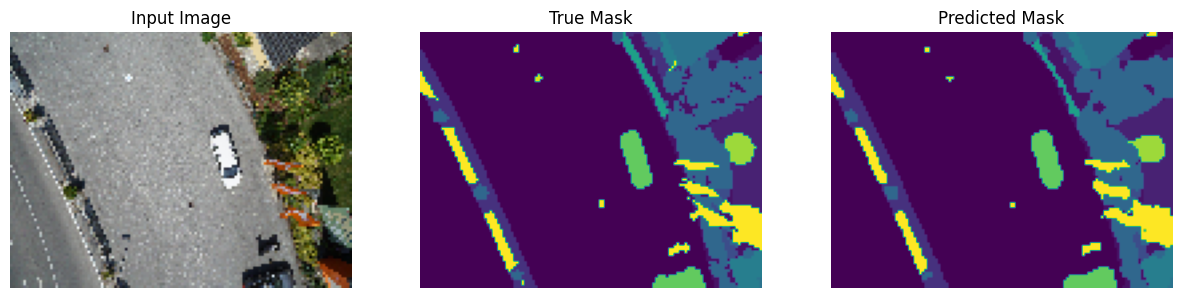

1/1 [==============================] - 0s 29ms/step


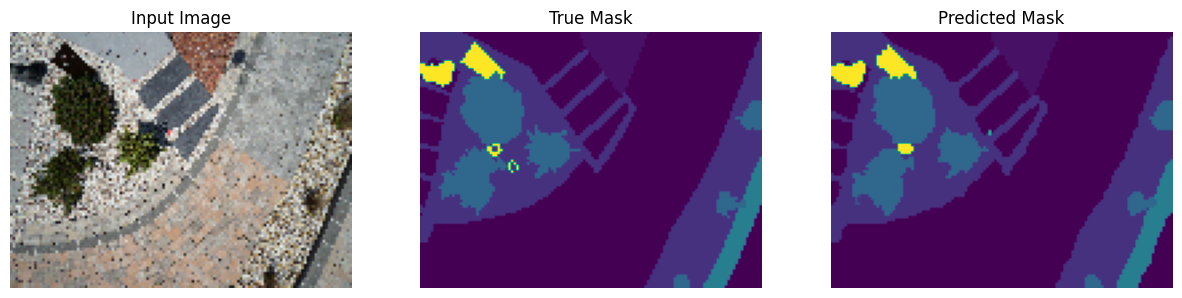

1/1 [==============================] - 0s 29ms/step


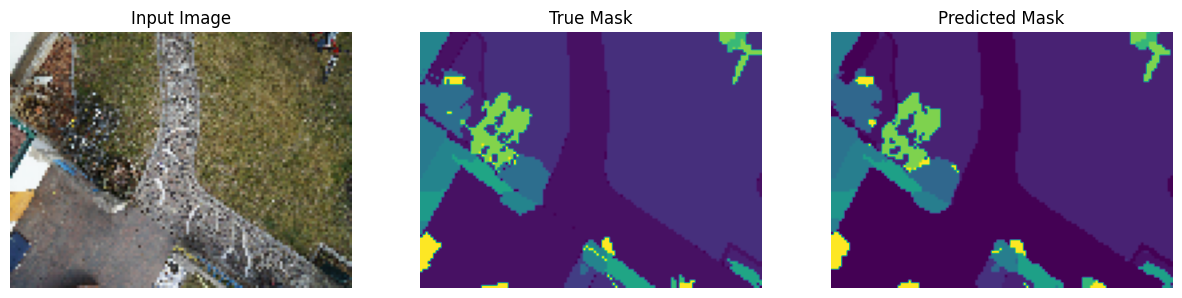

In [22]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])
show_predictions(train_dataset, 6)